In [1]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
import seaborn as sns
def imgpro(image_path, show = False):
    image = cv.cvtColor(cv.imread(image_path),cv.COLOR_BGR2RGB)
    if(show): plt.imshow(image)
    return image

In [2]:
path_1 = 'dataset/HAM10000_images_part_1'
path_2 = 'dataset/HAM10000_images_part_2'
meta_path = 'dataset/HAM10000_metadata.csv'
classes = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
encoder = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6
}
no_classes = len(classes)
meta = pd.read_csv(meta_path)
meta.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


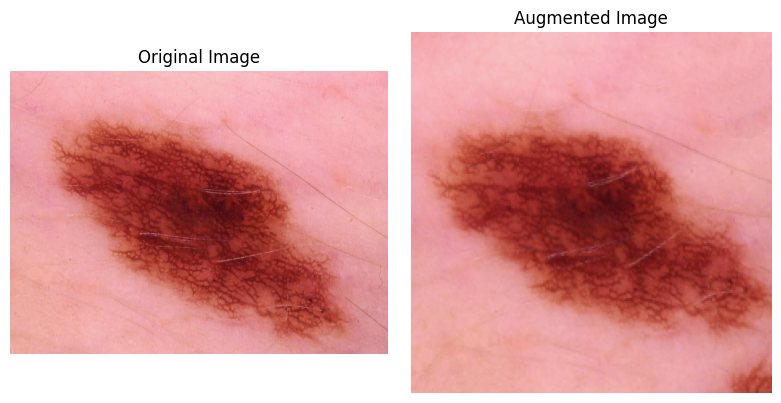

In [3]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

# Load and preprocess an image
image_path = 'dataset/HAM10000_images_part_1/ISIC_0024308.jpg'
try:
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Failed to load image: {image_path}")
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image_resized = cv2.resize(image_rgb, (224, 224))   # Resize to reduce memory usage

    # Apply data augmentation
    augmented_image = data_augmentation(np.expand_dims(image_resized, 0))

    # Convert the augmented image back to numpy array
    augmented_image_np = np.array(augmented_image[0], dtype=np.uint8)  # Remove batch dimension and convert to uint8

    # Display original and augmented images using matplotlib
    plt.figure(figsize=(8, 4))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title('Original Image')
    plt.axis('off')

    # Augmented image
    plt.subplot(1, 2, 2)
    plt.imshow(augmented_image_np)
    plt.title('Augmented Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error occurred: {e}")
